<a href="https://colab.research.google.com/github/anas1IA/Deeptweets_classification/blob/main/ANAS_NOURI_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ORACLE
# <center> MADC Intership Program Generic</center>
## <center> ML-Tweets Classification </center>
### <center> ANAS NOURI</center>
### <center>Rabat, Morocco, April 2024</center>

# About this task

The task is a binary classification for tweets into the two classes Politics and Sports using the tweet text as input.

In [213]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import string
from collections import Counter
import copy

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neural_network import MLPClassifier

import nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
# nltk.download('punkt')

from tqdm.auto import tqdm

import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from nltk.corpus import wordnet
import string
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [214]:
train =  pd.read_csv("train.csv")
training = pd.read_csv("training.csv")
test =  pd.read_csv("test.csv")

In [215]:
train.shape,training.shape,test.shape

((6525, 3), (6525, 3), (2610, 2))

In [216]:
if train.equals(training):
    print("The dataframes are equal")
else:
    print("The dataframes are not equal")

The dataframes are equal


In [217]:
test

,TweetId,TweetText
0,306486520121012224,'28. The home side threaten again through Maso...
1,286353402605228032,'@mrbrown @aulia Thx for asking. See http://t....
2,289531046037438464,'@Sochi2014 construction along the shores of t...
3,306451661403062273,'#SecKerry\u2019s remarks after meeting with F...
4,297941800658812928,'The #IPLauction has begun. Ricky Ponting is t...
...,...,...
2605,282023761044189184,'Qualifier 1 and Eliminator games will be play...
2606,303879735006601216,"@reesedward Hi Edward, it's not a #peacekeepin..."
2607,297956846046703616,'Perera was @SunRisersIPL first #IPL purchase ...
2608,304265049537658880,"'#SecKerry: Thanks to Senator @TimKaine, @RepR..."


We have two datasets that contain the same data, so we are just going to use one of them. In our case we are going to use the "train" dataset.

In [218]:
train

,TweetId,Label,TweetText
0,304271250237304833,Politics,'#SecKerry: The value of the @StateDept and @U...
1,304834304222064640,Politics,'@rraina1481 I fear so'
2,303568995880144898,Sports,'Watch video highlights of the #wwc13 final be...
3,304366580664528896,Sports,'RT @chelscanlan: At Nitro Circus at #AlbertPa...
4,296770931098009601,Sports,'@cricketfox Always a good thing. Thanks for t...
...,...,...,...
6520,296675082267410433,Politics,'Photo: PM has laid a wreath at Martyrs Monume...
6521,306677536195231746,Sports,'The secret of the Chennai pitch - crumbling o...
6522,306451295307431937,Sports,@alinabhutto he isn't on Twitter either
6523,306088574221176832,Sports,'Which England player would you take out to di...


In [219]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6525 entries, 0 to 6524
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   TweetId    6525 non-null   int64 
 1   Label      6525 non-null   object
 2   TweetText  6525 non-null   object
dtypes: int64(1), object(2)
memory usage: 153.1+ KB


# Data cleaning and Visualization

Let's try to gain insight on how our data is structured by using visualizations.

## General distribution

In [220]:
temp = train.groupby('Label').count()['TweetText'].reset_index().sort_values(by='TweetText',ascending=False)
temp.style.background_gradient(cmap='Blues')

,Label,TweetText
1,Sports,3325
0,Politics,3200


<Axes: xlabel='Label', ylabel='count'>

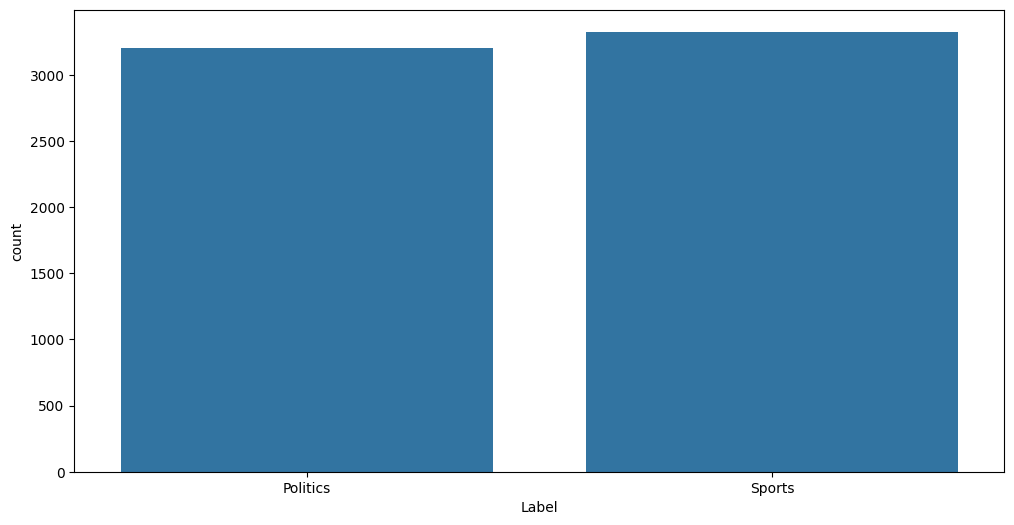

In [221]:
plt.figure(figsize=(12,6))
sns.countplot(x='Label',data=train)

The distribution of topics amoing the tweets in the train set is almost perfectly balanced.

## Text Cleaning
Tweets require lots of cleaning but it is inefficient to clean every single tweet because that would consume too much time. A general approach must be implemented for cleaning.

* The most common type of words that require cleaning in `oov` have punctuations at the start or end. Those words doesn't have embeddings because of the trailing punctuations. Punctuations `#`, `@`, `!`, `?`, `+`, `&`, `-`, `$`, `=`, `<`, `>`, `|`, `{`, `}`, `^`, `'`, `(`, `)`,`[`, `]`, `*`, `%`, `...`, `'`, `.`, `:`, `;` are separated from words
* Special characters that are attached to words are removed completely
* Contractions are expanded
* Urls are removed
* Character entity references are replaced with their actual symbols
* Typos and slang are corrected, and informal abbreviations are written in their long forms
* Some words are replaced with their acronyms and some words are grouped into one
* Finally, hashtags and usernames contain lots of information about the context but they are written without spaces in between words so they don't have embeddings. Informational usernames and hashtags should be expanded but there are too many of them. I expanded as many as I could, but it takes too much time to run `clean` function after adding those replace calls.

In [222]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    # text = re.sub('\w*\d\w*', '', text)
    return text

In [223]:
train['CleanTweetText'] = train['TweetText'].apply(lambda x:clean_text(x))
test['CleanTweetText'] = test['TweetText'].apply(lambda x:clean_text(x))

In [224]:
train.head()

,TweetId,Label,TweetText,CleanTweetText
0,304271250237304833,Politics,'#SecKerry: The value of the @StateDept and @U...,seckerry the value of the statedept and usaid ...
1,304834304222064640,Politics,'@rraina1481 I fear so',rraina1481 i fear so
2,303568995880144898,Sports,'Watch video highlights of the #wwc13 final be...,watch video highlights of the wwc13 final betw...
3,304366580664528896,Sports,'RT @chelscanlan: At Nitro Circus at #AlbertPa...,rt chelscanlan at nitro circus at albertpark ...
4,296770931098009601,Sports,'@cricketfox Always a good thing. Thanks for t...,cricketfox always a good thing thanks for the ...


## Most common words

If we print a list of the most common words now we are going to notice a common problem.

In [225]:
train['WordList'] = train['CleanTweetText'].apply(lambda x:str(x).split())
test['WordList'] = test['CleanTweetText'].apply(lambda x:str(x).split())
top = Counter([item for sublist in pd.concat([train['WordList'], test['WordList']]) for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','Count']
temp.style.background_gradient(cmap='Blues')

,Common_words,Count
0,the,5578
1,to,3381
2,in,2596
3,of,2575
4,a,2008
5,for,1924
6,and,1784
7,on,1710
8,rt,1286
9,is,1134


The most frequent words are what is called *stopwords* in Natural Language Processing, and they provide little information about the message, so we are going to have to remove them.

In [226]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]
train['WordList'] = train['WordList'].apply(lambda x:remove_stopword(x))
test['WordList'] = test['WordList'].apply(lambda x:remove_stopword(x))

Now let's see what the most common words by category are.

In [227]:
def split_by_category(df):
    df_sports = df.loc[df['Label'] == "Sports"]
    df_politics = df.loc[df['Label'] == "Politics"]
    return df_sports, df_politics

In [228]:
train_sports, train_politics = split_by_category(train)

### Most common words used to talk about Sports

In [229]:
top_sports = Counter([item for sublist in train_sports['WordList'] for item in sublist])
temp = pd.DataFrame(top_sports.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','Count']
temp.style.background_gradient(cmap='Oranges')

,Common_words,Count
1,indvaus,347
2,test,314
3,1st,220
4,bcci,201
5,runs,196
6,bbl02,194
7,atp,181
8,amp,177
9,bigfinals,165
10,cfc,162


### Most common words used to talk about Politics

In [230]:
top_politics = Counter([item for sublist in train_politics['WordList'] for item in sublist])
temp = pd.DataFrame(top_politics.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','Count']
temp.style.background_gradient(cmap='Purples')

,Common_words,Count
1,rt,368
2,president,329
3,obama,236
4,pm,188
5,conference,159
6,video,155
7,new,152
8,press,140
9,medvedev,138
10,nelsonmandela,136


Are we can see, now the different topics use clearly different words.

In [231]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size,
                    random_state = 42,
                    width=400,
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text).replace("'",''))

    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black',
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    # plt.tight_layout()

## Wordclouds

Let's visualize the most used words per category with wordclouds.

### Sports wordcloud

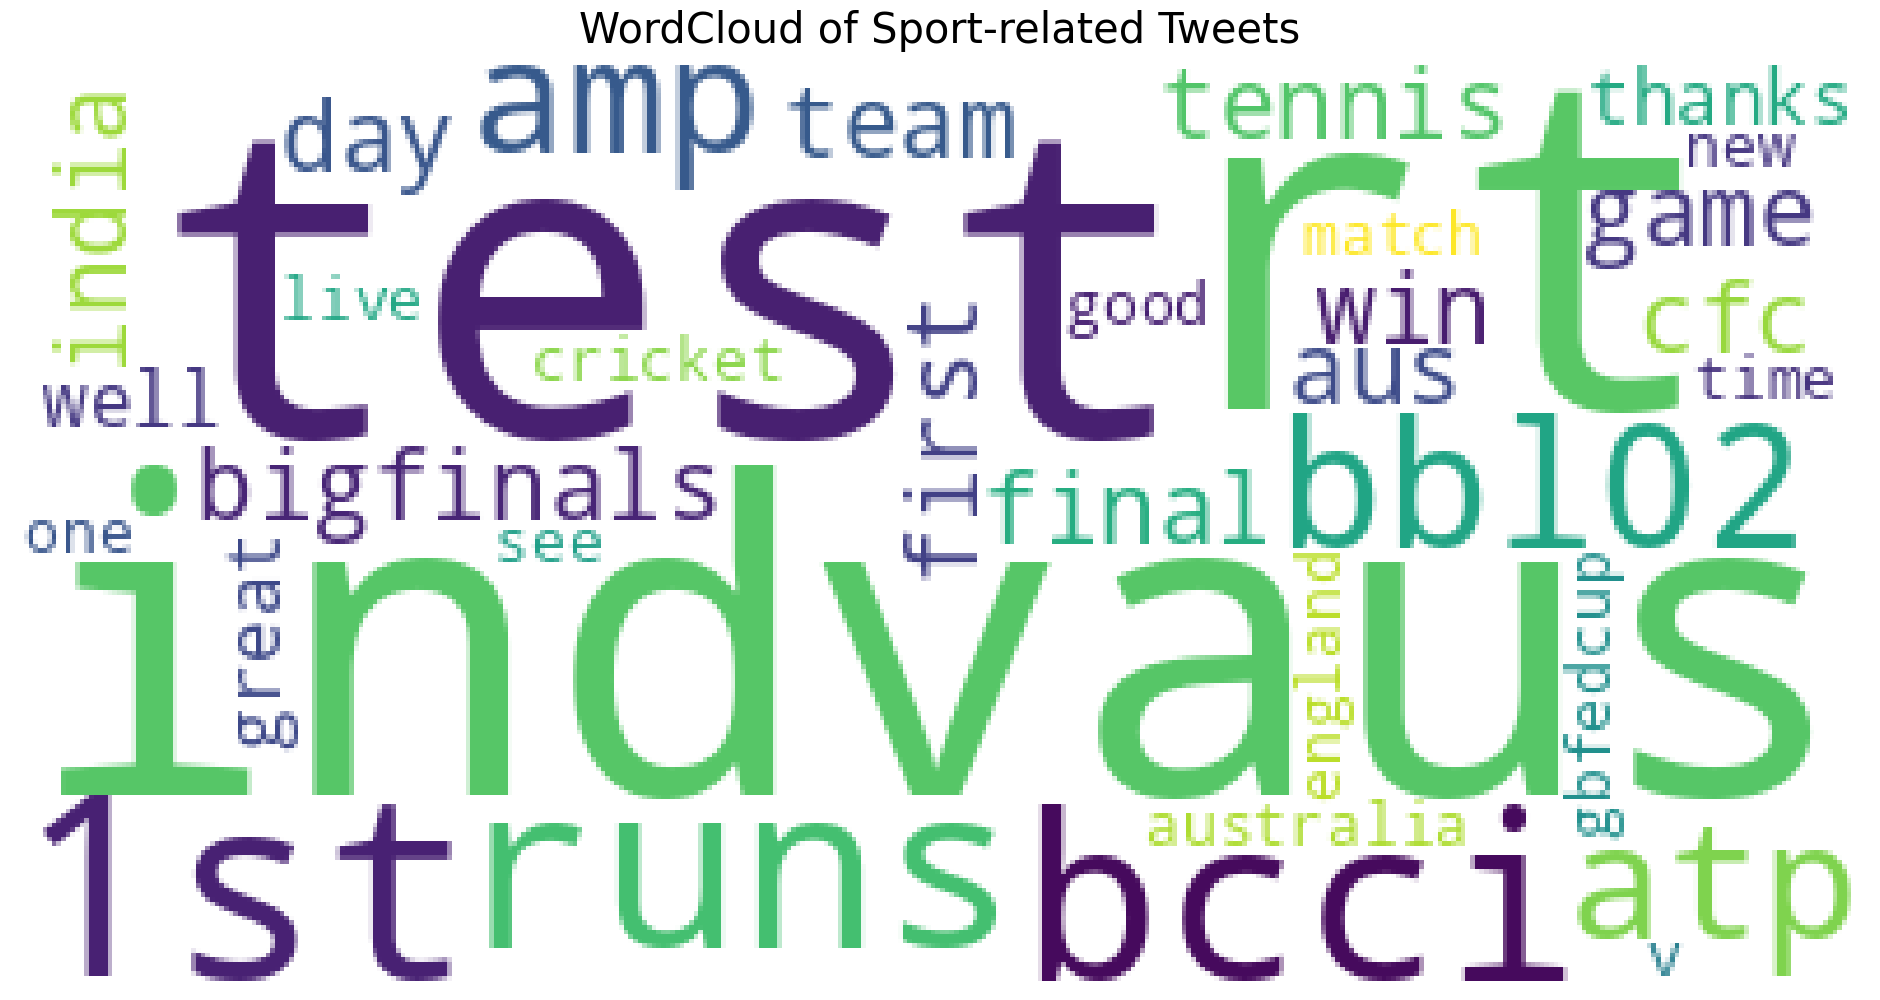

In [232]:
plot_wordcloud(top_sports.most_common(40),color='white',max_font_size=100,title_size=30,title="WordCloud of Sport-related Tweets")

### Politics wordcloud

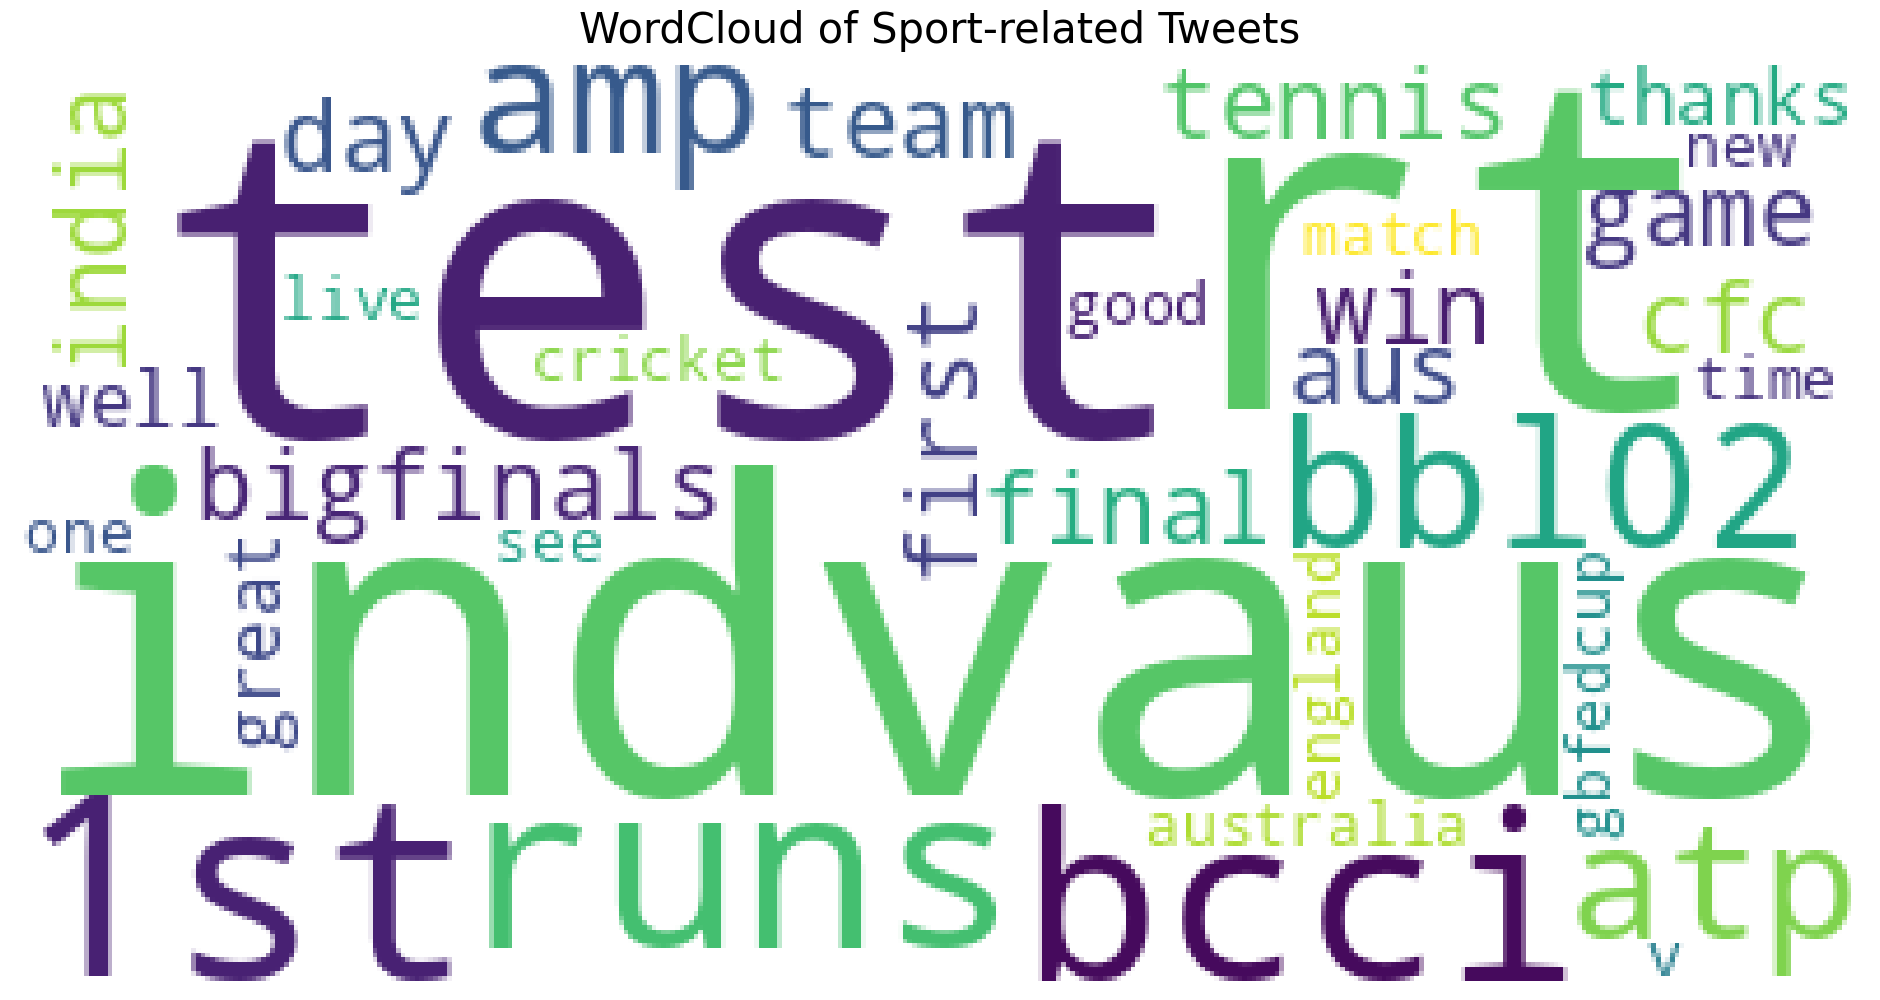

In [233]:
plot_wordcloud(top_sports.most_common(40),color='white',max_font_size=100,title_size=30,title="WordCloud of Sport-related Tweets")

# Feature extraction

Feature extraction is the process of extracting useful features from raw data. We are going to use different approaches to study our data.

## Word Frequency

Our first approach will be looking at word frequency. Word frequency is a feature extraction method used in natural language processing and information retrieval that involves counting the frequency of each word in a corpus of documents, and using the resulting counts as features.

In [234]:
train_tweet_tokens = train['WordList']

# Get a set of all the unique words
train_vocab = set([word for tweet in train_tweet_tokens for word in tweet])

# Convert the set back to a list
train_vocab = list(train_vocab)

# Create a one-hot encoded matrix
X_train = np.zeros((len(train_tweet_tokens), len(train_vocab)))

# Iterate over the tweet tokens and vocab and fill in the matrix
for i, tweet in tqdm(enumerate(train_tweet_tokens), total=len(train_tweet_tokens)):
    for j, word in enumerate(train_vocab):
        X_train[i, j] = tweet.count(word)
        # print(X_train[i,j])

  0%|          | 0/6525 [00:00<?, ?it/s]

In [235]:
y_train = train['Label'].to_numpy()

In [236]:
y_train

array(['Politics', 'Politics', 'Sports', ..., 'Sports', 'Sports',
       'Politics'], dtype=object)

In [237]:
test_tweet_tokens = test['WordList']
X_test = np.zeros((len(test_tweet_tokens), len(train_vocab)))

for i, tweet in tqdm(enumerate(test_tweet_tokens), total=len(test_tweet_tokens)):
    for j, word in enumerate(train_vocab):
        X_test[i, j] = tweet.count(word)
        # print(X_test[i,j])

  0%|          | 0/2610 [00:00<?, ?it/s]

We compare the vocabs in the train and test set.

In [238]:
test_tweet_tokens = test['WordList']

# Get a set of all the unique words
test_vocab = set([word for tweet in test_tweet_tokens for word in tweet])

# Convert the set back to a list
test_vocab = list(test_vocab)

In [239]:
print(len(train_vocab), len(test_vocab))

14727 7456


The test set has a much smaller pool of words. Let's see if there are any words
in the test set that aren't in the train set.

In [240]:
if all(word in train_vocab for word in test_vocab):
  print("All words in test_vocab are present in train_vocab")
else:
  print("Not all words in test_vocab are present in train_vocab")

Not all words in test_vocab are present in train_vocab


Let's see how many.

In [241]:
len([word for word in test_vocab if word not in train_vocab])

3628

About half of the words in the test set are not in the train set. This tells us that word frequency is not going to be a very useful predictor on the test set, since most of the context is going to be different. Let us proceed anyhow.

Let's see how our train matrix looks like.

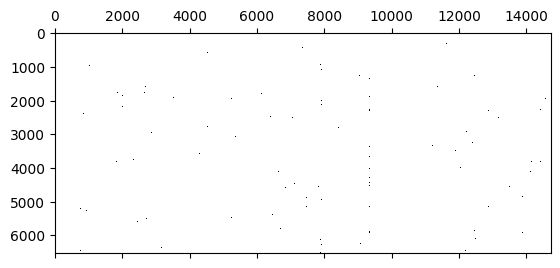

In [242]:
plt.spy(X_train)

We can see it's extremely sparse. Some dimentionality reduction would be useful.

### Frequency Threshold

To reduce the dimensionality of the dataset, we can put a theshold on the minimum frequency a word needs to have to appear as a feature.

In [243]:
train_vocab_freqs = np.sum(X_train, axis=0)

# Get the list of words
words = [word for word in train_vocab]

# Create a dataframe with the words and frequencies
word_frequencies = pd.DataFrame({'Word': train_vocab, 'Frequency': train_vocab_freqs})

# Sort the dataframe by frequency in descending order
word_frequencies = word_frequencies.sort_values(by='Frequency', ascending=False)

# Display the dataframe
print(word_frequencies)

            Word  Frequency
10864         rt      891.0
10872        amp      599.0
11445    indvaus      347.0
3473   president      330.0
8534        test      328.0
...          ...        ...
8881         bag        1.0
3763       chips        1.0
8879   intervene        1.0
8878   mustreads        1.0
14726   sayasone        1.0

[14727 rows x 2 columns]


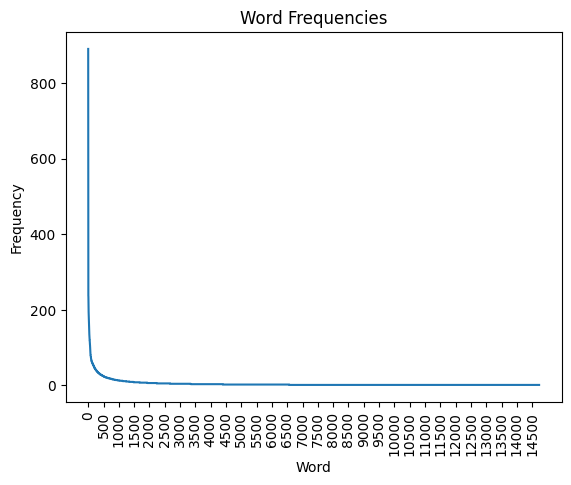

In [244]:
plt.plot(word_frequencies['Word'], word_frequencies['Frequency'])

plt.title('Word Frequencies')
plt.ylabel('Frequency')
plt.xlabel('Word')
plt.xticks(range(0, len(word_frequencies['Word']),500), range(0, len(word_frequencies['Word']),500), rotation=90)

# Show the plot
plt.show()

Only the words in the top 1000 have high usage, after that usage drops drastically. We could probably discard a lot of those words without losing much accuracy.

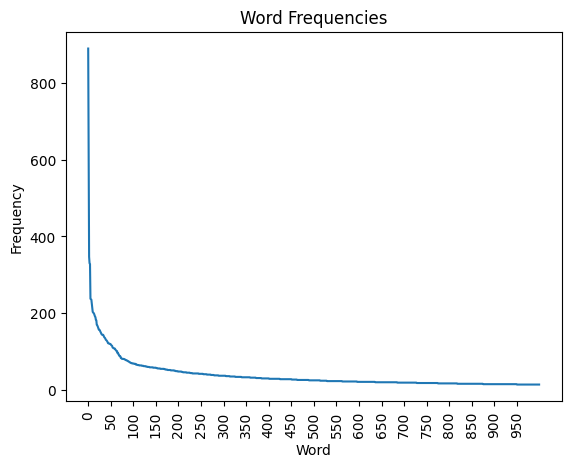

In [245]:
plt.plot(word_frequencies['Word'][0:1000], word_frequencies['Frequency'][0:1000])

plt.title('Word Frequencies')
plt.ylabel('Frequency')
plt.xlabel('Word')
plt.xticks(range(0, 1000, 50), range(0, 1000, 50), rotation=90)

plt.show()

In [246]:
# Sort dataset columns by descending word frequencies
X_train_1 = X_train[:, list(word_frequencies.index)]
X_test_1 = X_test[:, list(word_frequencies.index)]

In [247]:
# Cut the dataset by minimum frequency
def frequency_threshold_cut(dataset, threshold):
    return dataset[:, 0:threshold]

### PCA

We will use Principal Component Analysis to reduce the dimentionality of the word frequency reperesention by adjusting the number of principal components.

In [45]:
pca = PCA(n_components=2)

pca.fit(X_train)

X_train_pca = pca.transform(X_train)

# Extract the data projected to the principal components
x = X_train_pca[:, 0]
y = X_train_pca[:, 1]



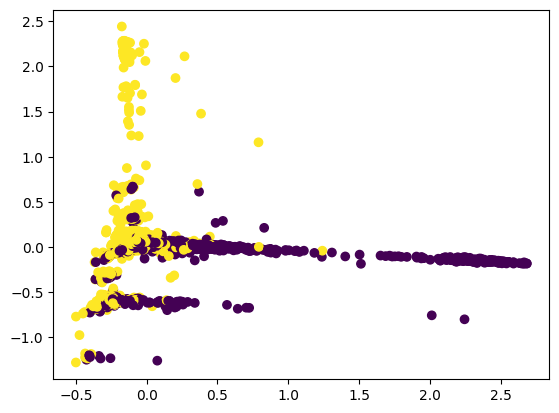

In [44]:
# Create a scatter plot with different colors for the points
plt.scatter(x, y, c=[1 if label=='Politics' else 0 for label in y_train])

# Show the plot
plt.show()

The graph shows that the majority of the *Sports* tweets and the *Politics* tweets can be separated with just 2 principal components.

In [46]:
max_rank = min(X_train.shape[0], X_train.shape[1])

pca = PCA(max_rank)

pca.fit(X_train)

PCA(n_components=6525)

In [47]:
def pca_reduce_dimensionality(pca, dataset, n_components):
    pca_n_comps = copy.deepcopy(pca)
    pca_n_comps.n_components_ = n_components
    pca_n_comps.components_ = pca.components_[0:n_components]

    return pca_n_comps.transform(dataset)

## TF-IDF

Term Frequency - Inverse Document Frequency (TF-IDF) is a statistical measure that is used to evaluate the importance of a word in a document or a collection of documents by multiplying the term frequency by the inverse document frequency for each word in a document. The resulting value is higher for words that are more important to the meaning of the document, and lower for words that are less important or more common.

In [164]:
# from scipy.sparse import vstack

tfidf = TfidfVectorizer()
tfidf_train = tfidf.fit(train['CleanTweetText'])
tfidf_test = tfidf.fit(test['CleanTweetText'])
X_train_tfidf = tfidf_train.transform(train['CleanTweetText'])
X_test_tfidf = tfidf_test.transform(test['CleanTweetText'])

# # Define the number of topics or components
# num_components=500

# # Create SVD object
# lsa = TruncatedSVD(n_components=num_components, n_iter=100, random_state=42)

# # Fit SVD model on data
# lsa.fit(vstack((X_train_tfidf, X_test_tfidf)))
# X_train_lsa = lsa.transform(X_train_tfidf)
# X_test_lsa = lsa.transform(X_test_tfidf)

In [165]:
X_train_tfidf.shape


(6525, 7550)

## E5

Text embedding is a technique used to map words or phrases in a text to a numerical vector space. The goal of text embedding is to capture the meaning of the words and the relationships between them in a way that can be used by machine learning models.

There are several different methods for creating text embeddings. They all involve training a model on a large dataset of text, such as a corpus of news articles or a collection of Wikipedia pages. The model learns to predict the likelihood of a word occurring given the context of the surrounding words, and uses this information to create a high-dimensional vector representation of each word.

Text embeddings are useful because they allow machine learning models to take into account the meaning of words in a text, rather than just treating them as individual tokens. This makes it possible to use the embeddings to perform tasks such as text classification, language translation, and text generation.

E5 is a family of state-of-the-art text embeddings that transfer well to a wide range of tasks. The model is trained in a contrastive manner with weak supervision signals from a curated large-scale text pair dataset.

*Text Embeddings by Weakly-Supervised Contrastive Pre-training. Liang Wang, Nan Yang, Xiaolong Huang, Binxing Jiao, Linjun Yang, Daxin Jiang, Rangan Majumder, Furu Wei, arXiv 2022*

## Model Training.

In [249]:
y_train = train['Label'].to_numpy()
y_train

array(['Politics', 'Politics', 'Sports', ..., 'Sports', 'Sports',
       'Politics'], dtype=object)

In [167]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y_train, test_size=0.2, random_state=142)

# Train the model
model = MultinomialNB(alpha=2)
model.fit(X_train, y_train)

MultinomialNB(alpha=2)

              precision    recall  f1-score   support

    Politics       0.96      0.93      0.94      2553
      Sports       0.93      0.96      0.95      2667

    accuracy                           0.94      5220
   macro avg       0.94      0.94      0.94      5220
weighted avg       0.94      0.94      0.94      5220

score train: 0.94 test: 0.91


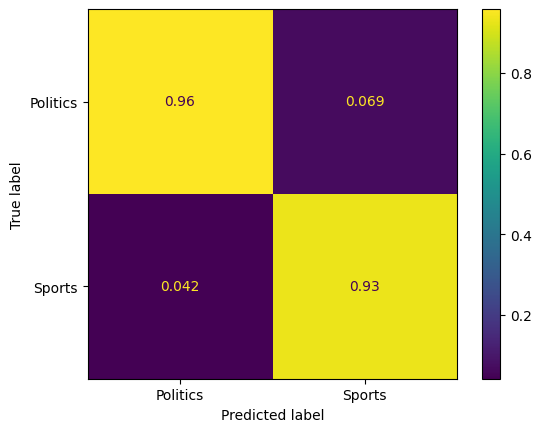

In [168]:
y_predict = model.predict(X_train)

print("{}\nscore train: {:.2} test: {:.2}".format(
    classification_report(y_train, y_predict),
    model.score(X_train, y_train), model.score(X_test, y_test)
))

ConfusionMatrixDisplay(
    confusion_matrix(y_train, y_predict, normalize='pred'),
    display_labels=["Politics", "Sports"],
).plot()

              precision    recall  f1-score   support

    Politics       0.93      0.88      0.90       647
      Sports       0.89      0.93      0.91       658

    accuracy                           0.91      1305
   macro avg       0.91      0.91      0.91      1305
weighted avg       0.91      0.91      0.91      1305

score train: 0.94 test: 0.91


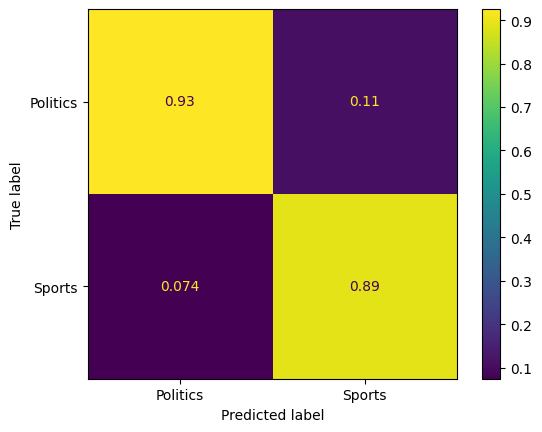

In [169]:
y_predict = model.predict(X_test)

print("{}\nscore train: {:.2} test: {:.2}".format(
    classification_report(y_test, y_predict),
    model.score(X_train, y_train), model.score(X_test, y_test)
))

ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_predict, normalize='pred'),
    display_labels=["Politics", "Sports"],
).plot()

### LogisticRegression

In [250]:
# Word Frequency (No feature selection) Cross-validation

model = LogisticRegression()

# Use the cross_val_score function to evaluate the model using 5-fold cross-validation
scores = cross_val_score(model, X_train_1, y_train, cv=5)

raw_freq_cv_score = scores.mean()

# Print the mean and standard deviation of the cross-validated scores
print("Mean accuracy: {:.4f} (+/- {:.4f})".format(scores.mean(), scores.std()))

Mean accuracy: 0.9439 (+/- 0.0038)


#### Prediction

In [251]:
# Word Frequency (No feature selection) Generate prediction

model.fit(X_train, y_train)

test['Label'] = model.predict(X_test)

submission_prediction = test[['TweetId', 'Label']]

submission_prediction.to_csv('freq_prediction.csv', index=False)

### Frequency Threshold

To find the optimal value for the threshold, we evaluate the crossvaluation scores and then apply the cut to the dataset.

#### Performance

In [254]:
def score_per_pca_feature_selection(threshold):

    X_train_threshold = frequency_threshold_cut(X_train, threshold)

    model = LogisticRegression()

    scores = cross_val_score(model, X_train_threshold, y_train, cv=5)

    return scores.mean()

In [255]:
# PCA Cross-evaluation
scores = []

for thr in tqdm(range(5, 101, 5)):
    scores.append((thr, score_per_pca_feature_selection(math.ceil(max_rank * thr / 100))))

print(scores)

  0%|          | 0/20 [00:00<?, ?it/s]

[(5, 0.5682758620689655), (10, 0.6121072796934867), (15, 0.6481226053639848), (20, 0.6773946360153257), (25, 0.7025287356321839), (30, 0.7272030651340996), (35, 0.7471264367816092), (40, 0.760919540229885), (45, 0.7685823754789272), (50, 0.7828352490421455), (55, 0.8122605363984675), (60, 0.8186973180076628), (65, 0.8283524904214559), (70, 0.8367816091954022), (75, 0.8470498084291187), (80, 0.8531800766283524), (85, 0.8613026819923372), (90, 0.8646743295019157), (95, 0.8695785440613026), (100, 0.8770881226053641)]


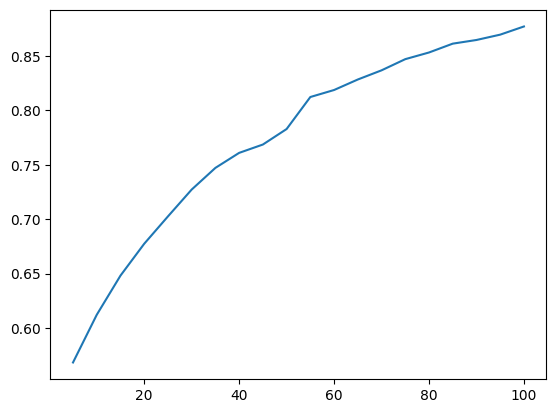

In [256]:
# Extract the values from the scores tuples
x = [score[0] for score in scores]
y = [score[1] for score in scores]

# Create a line plot
plt.plot(x, y)

# Show the plot
plt.show()

In [257]:
# Best score
freq_pca_best_score = max(scores, key=lambda x:x[1])
best_scoring_percentage = freq_pca_best_score[0]

print(freq_pca_best_score)

(100, 0.8770881226053641)


In [258]:
# PCA Generate prediction

best_scoring_n_components = math.ceil( max_rank * best_scoring_percentage / 100 )
pca = PCA(n_components = best_scoring_n_components)

pca.fit(X_train)

X_train_pca = pca.transform(X_train)
model.fit(X_train_pca, y_train)

X_test_pca = pca.transform(X_test)

test['Label'] = model.predict(X_test_pca)

submission_prediction = test[['TweetId', 'Label']]

submission_prediction.to_csv('pca_prediction.csv', index=False)